<a href="https://colab.research.google.com/github/johnrfrank/face-recognition-exploration/blob/main/face_recognition_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Exploration

[Face recognition](https://en.wikipedia.org/wiki/Facial_recognition_system) is a hot topic.  It's fascinating, controversial, and now available to everyone.

**Question:**  How do computers recognize faces?

**Answer:** A person **trains** a machine learning **model** using **example** data.

The idea of training a computer dates back to [Leslie Valiant](https://en.wikipedia.org/wiki/Leslie_Valiant)'s famous paper ["A Theory of the Learnable"](https://dl.acm.org/doi/pdf/10.1145/1968.1972) from 1984 in which he proved that learning can be accomplished by *labeling* natural inputs. 

The process of training computer program has much in common with our human experience of learning.  The learning procedure relies on *errors*.  We often call such a trained program a "model."  In order to create a model, one starts with an initial model and then iteratively adjusts or corrects the model.  In each iteration (step) of the training procedure, we show the current model an example (e.g. a photo of a person's face) and get the model's output (e.g. the name of the person).  Then, we compare that output to the "truth label" on that example.  If the model was correct, then no change is needed --- the training procedure cannot improve the model.  If the model's answer was incorrect, then the training procedure can *attempt* a change to the model with the hope of improving the model for future iterations.  

**Note** that **no learning** improvement happens **without mistakes!**

In this notebook, we will explore three aspects of this grand plan:
* Where do we get labeled examples of faces?
* What does a successful model do?  **Let's play with one!**
* **Learning Procedure:** What does an "initial model" look like, and how do we "attempt a change to it" when it makes an error?

## Labeled examples of faces?

As a gift to computer science researchers everywhere, [Prof. Erik Learned-Miller](https://www.umass.edu/newsoffice/article/cics-professor-erik-learned-miller) and his students created a database of thousands of [photos of people along with their names](http://vis-www.cs.umass.edu/lfw/lfw.pdf).  You can [download and explore the data set](http://vis-www.cs.umass.edu/lfw/index.html#explore).

Facial recognition technologies (FRT) has become a mainstream topic because it enables new things, some good and some bad.  You can read more about its implications for public policy in this [FRT Primer](https://people.cs.umass.edu/~elm/papers/FRTprimer.pdf).


## Let's play with a working model
The notebook below illustrates how an already-trained model recognizes faces in images.  This uses a few tools that you can pick up and use in your own programs: 

* [Face Recognition](https://pypi.org/project/face-recognition/) a python wrapper around [Dlib](http://dlib.net/) written in C++.  It comes with pre-trained models.
* [facial expression recognition (FER)](https://pypi.org/project/fer/) 
* [OpenCV2](https://opencv.org/about/) library provides thousands of algorithms for computer vision.

Much of this is copied from notebooks that I found on the web: (1) Dev Dash's [Face Recognition notebook](https://colab.research.google.com/drive/10HRlLZR3q6ncEmYbEFmn2lEUQqaQXY5L?authuser=1#scrollTo=4DDeKzSd_NB9) from this [blog post about how to do this in python](https://towardsdatascience.com/two-step-facial-recognition-with-colab-883a54faafad), and (2) Abhay Parashar's [Face Recognition System Using Google Colab](https://levelup.gitconnected.com/face-recognition-system-using-google-colab-ccca1d56f5f3)

Google Colab is a browser-based tool for running code on cloud-based resources (computers).  It gives you a [shell environment](https://linuxcommand.org/lc3_lts0010.php) in which you can run [python](https://www.python.org/).  

In this notebook, you'll notice some lines that begin with an exclamation point !, which means "run the following command in the shell environment where the rest of python code runs."


In [ ]:
#@title Link your Google Drive so your images and model files will be saved there.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Load libraries into the shell
!pip install -q face_recognition
!pip install -q fer

# Import these two key libraries into the python interpretter
import face_recognition
from fer import FER

# create an instance of the Facial Emotion Recognizer
emotion_detector = FER() 

# import CV2 and patch part of it to work here in Google Colab
import cv2
from google.colab.patches import cv2_imshow

# import a bunch of supporting libraries
from io import BytesIO
from google.colab import files
from hashlib import sha256
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
from PIL import ImageDraw, Image
import PIL.Image
import operator
import time


     |████████████████████████████████| 100.2MB 42kB/s 
     |████████████████████████████████| 819kB 16.9MB/s 
     |████████████████████████████████| 2.3MB 55.0MB/s 
Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', mesg='Press any key!', quality=0.8):
    js = Javascript('''
    async function takePhoto(mesg_txt, quality) {
      const div = document.createElement('div');
      div.innerHTML = mesg_txt;

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);
      await new Promise((resolve) => document.body.onkeydown = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto("{0}", {1})'.format(mesg, quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as fh:
        fh.write(binary)
    return filename

# Building Blocks

In this section, we'll explore the individual steps.  You can take one picture at a time and see how the parts work.  In the section titled *Training an Indentification Model* we'll put these together to create our own trained model for recognizing specific faces.

In [ ]:
#@title To start, you can take a picture with your web cam
filename = take_photo()
print("saved your webcam picture to " + filename)

<IPython.core.display.Javascript object>

saved your webcam picture to photo.jpg


Alternatively, this will allow you to upload an image.  You can pick any image you want. Here's an image with many faces that is good for experimenting.  Warning: uploading an image will replace the image taken with your camera above.

https://unsplash.com/photos/1qfy-jDc_jo

In [ ]:
#@title or, you can upload image with faces -- will replace your web cam photo
uploaded = files.upload() 
filename = list(uploaded.keys())[0]

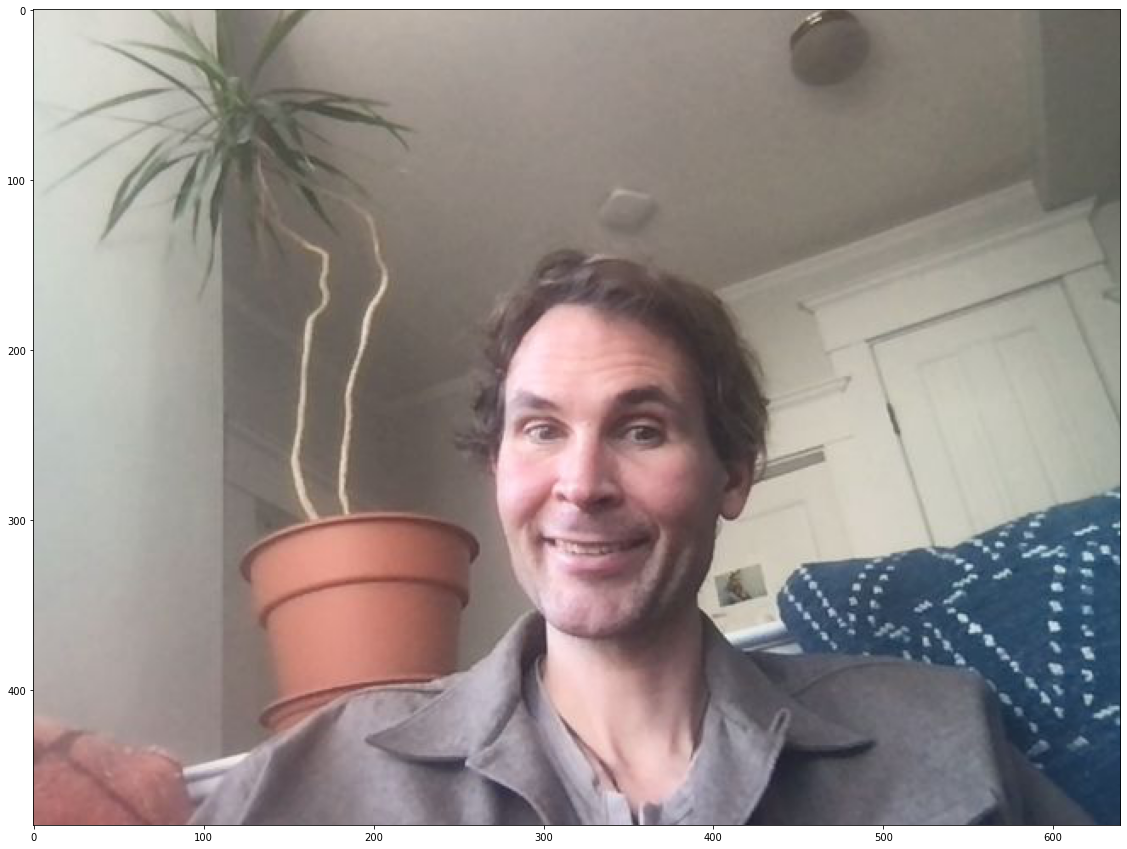

In [ ]:
#@title Display image
image = face_recognition.load_image_file(filename)
boundary = 24
im = PIL.Image.open(filename)
height = (im.size[1] / im.size[0]) * 20
fig = plt.subplots(figsize=(20, height))
imshow(im)

Number of faces: 1
Time taken: 0.23  seconds


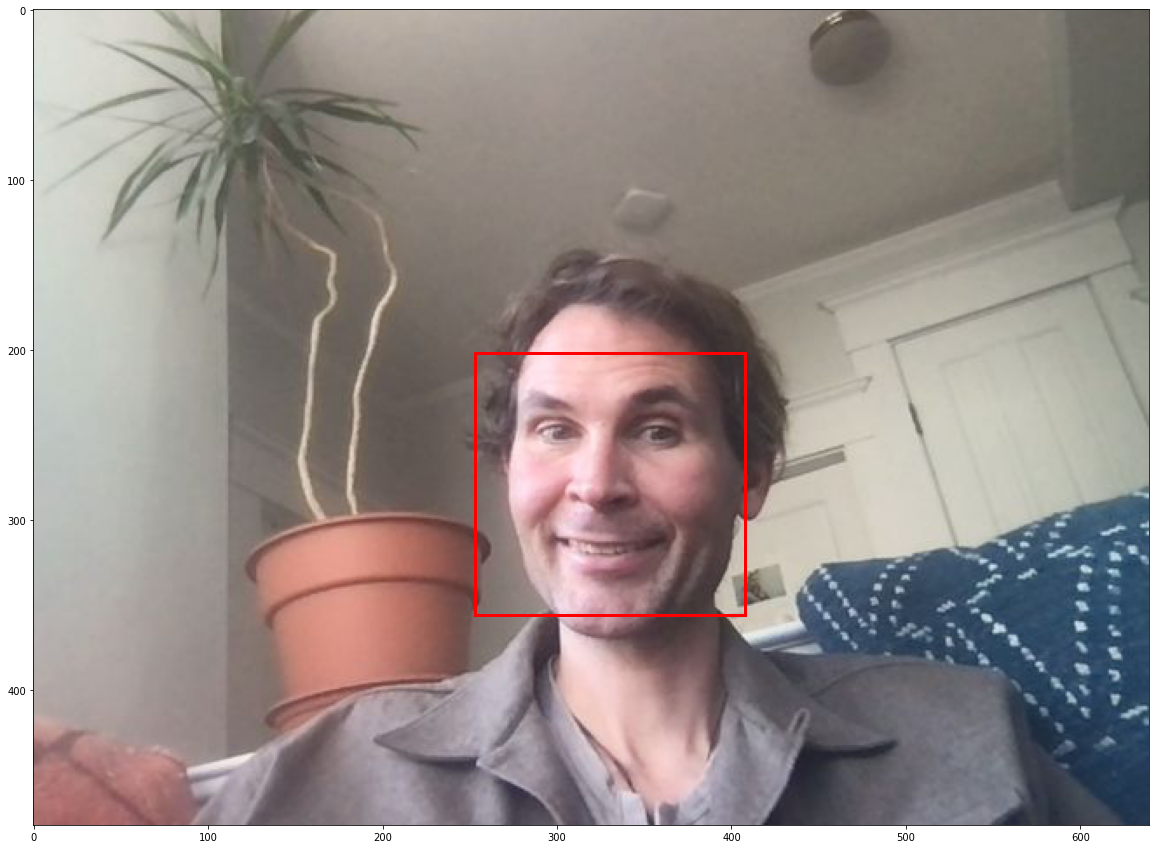

In [ ]:
#@title Use 'Face Recognition' library and draw a red box around the faces

# let's capture the current time, so we can see how long this takes
start = time.time()

# The package "face_recognition" has a function called "face_locations"
# that returns a list of pixel locations for faces.
face_locations = face_recognition.face_locations(image)

# using the matplotlib package, we can draw red boxes
fig, ax = plt.subplots(figsize=(20, height))
for face_location in face_locations:
    top, right, bottom, left = face_location 
    ax.imshow(im, aspect='auto')
    rect = patches.Rectangle((left,top), (right - left), (bottom-top),linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

# let's print a message about how long it took and what was found
end = time.time()
print("Number of faces:", len(face_locations))
print("Time taken:", round(end - start, 2)," seconds")

happy
Number of faces: 1
Time taken: 7.1941022872924805  seconds


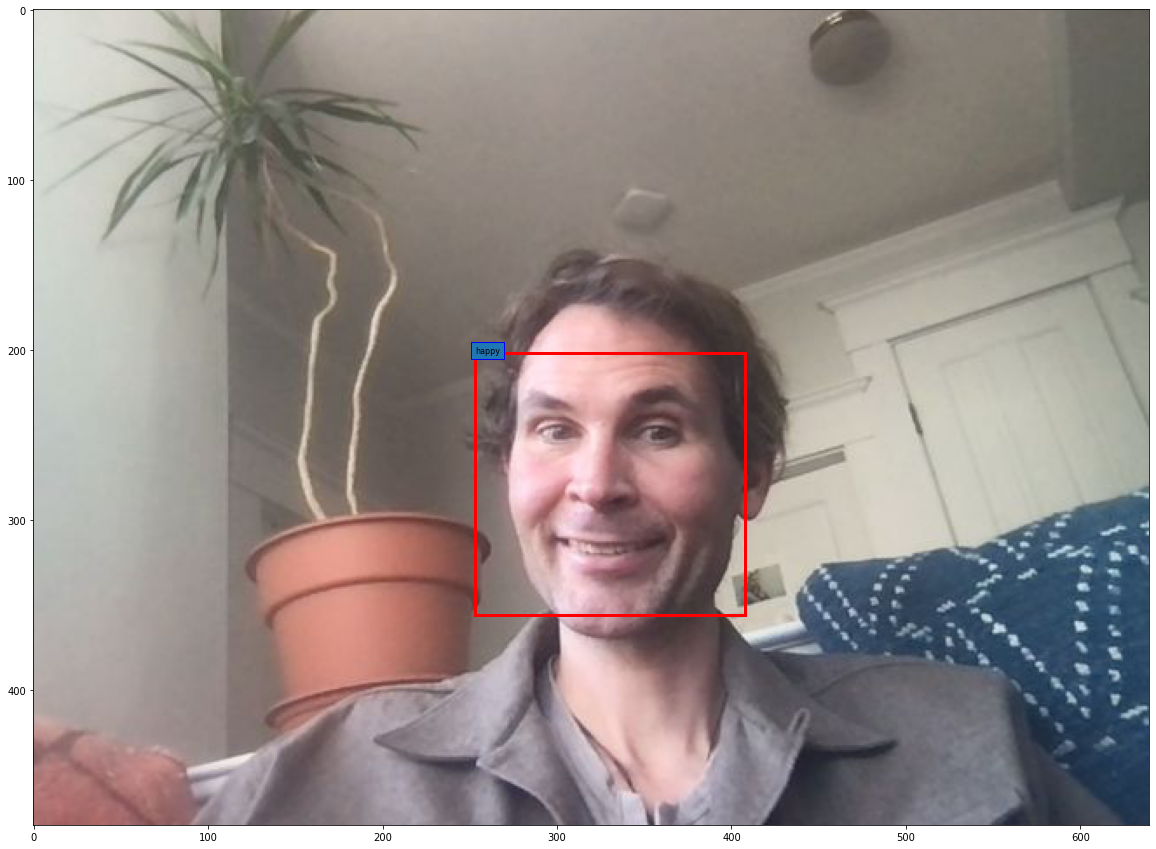

In [ ]:
#@title Use 'Face Recognition' library and draw a red box around the faces as well as predicted emotion
# same as above with the addition of *emotion detection*
start = time.time()
face_locations = face_recognition.face_locations(image)
fig, ax = plt.subplots(figsize=(20, height))
for face_location in face_locations:
    top, right, bottom, left = face_location 
    # get the tiny image of just this one face
    face_image = image[top - boundary:bottom + boundary, 
                       left - boundary:right + boundary]
    # pass it into the FER detector we created above
    attribute = emotion_detector.detect_emotions(face_image)
    if (not attribute) == False:
        # get the most likely emotion
        emotion = max(attribute[0]['emotions'].items(), key=operator.itemgetter(1))[0]
        print(emotion)
        plt.text(left, top, emotion, fontsize=8, bbox=dict(fill=True, edgecolor='blue', linewidth=1))
    ax.imshow(im,aspect='auto')
    if emotion == 'happy':
        edgecolor='r'
    elif emotion == 'neutral':
        edgecolor='r'
    else:
        edgecolor='r'
    rect = patches.Rectangle((left, top), (right - left), (bottom - top),
                             linewidth=3, edgecolor=edgecolor, 
                             facecolor='none')
    ax.add_patch(rect)
end = time.time()
print("Number of faces:",len(face_locations))
print("Time taken:",end-start," seconds")

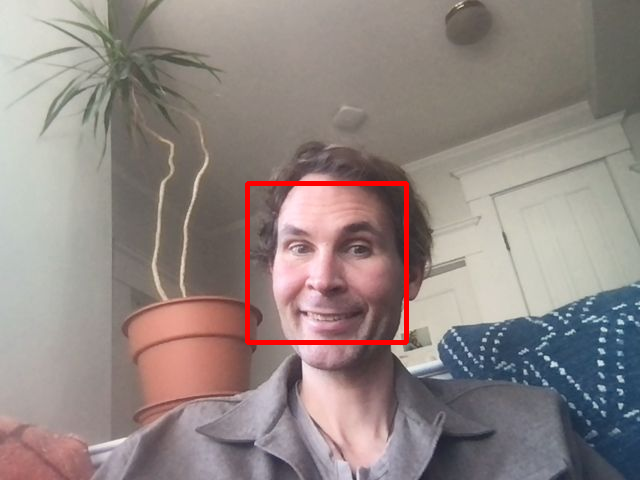

Time taken: 0.19383478164672852  seconds
Number of faces: 1


In [ ]:
#@title Switch models!  Let's try "Haar Cascades" to do the same task.

start = time.time()

# Load the cascade model from CV2, so switching from dlib to cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Read the input image
img = cv2.imread(filename)

# Convert into GrayScale, because CV2 wants gray images
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect Faces
faces = face_cascade.detectMultiScale(gray, 1.3, 4)
# Draw rectangle around each faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 3)
# Display the output
ims = cv2.resize(img,(im.size[0],im.size[1]))
cv2_imshow(ims)
cv2.waitKey()
end = time.time()
print("Time taken:",end-start," seconds")
print("Number of faces:",len(faces))

How is this magic possible!?

These python libraries are wrappers around *pre-trained* models.

For example, here are [the actual model files](https://github.com/ageitgey/face_recognition_models/tree/master/face_recognition_models/models) used in [Adam Geitgey](https://www.adamgeitgey.com/)'s [python `face_recognition` package](https://github.com/ageitgey/face_recognition).  (Note that Mr. Geitgey has created several online classes about machine learning!)  Here's more detail about how [Davis King](https://github.com/davisking/)'s [trained the face recog ResNet v1](https://github.com/davisking/dlib-models#dlib_face_recognition_resnet_model_v1datbz2) and 

Now, if you download one of those model files and try to open it, you'll find that it looks like gibberish, or if you use the right tools, like a bunch of numbers, something like this:

`
[-1.30204931e-01  7.25175142e-02  1.15522249e-02 -7.06830695e-02
 -2.02417314e-01 -1.89411566e-02 -1.44570954e-02 -5.92008829e-02
  2.37556070e-01 -1.16061360e-01  2.33713791e-01 -3.24947126e-02
 -3.01599085e-01  1.06434077e-02 -5.16676828e-02  2.35995024e-01
 -2.63825774e-01 -1.29623830e-01 -3.12887914e-02 -2.52737552e-02
  8.67748260e-03  7.06981122e-02  2.89485529e-02  1.45714030e-01]
`


#Learning Procedures
* How did that set of numbers emerge?
* What does an "initial model" look like, and 
* How do we "attempt a change to it" when it makes an error?

One of the more sophisticated approaches to machine learning uses ["layers of neurons"](https://en.wikipedia.org/wiki/Residual_neural_network) that [resemble biological brains](https://en.wikipedia.org/wiki/Cerebral_organoid#:~:text=Cerebral%20organoids%20are%20most%20similar,is%20dependent%20on%20many%20factors).  Before we get to that, let's examine a simpler learning procedure called "gradient descent," which uses a simpler analogy:  [climbing a hill](https://en.wikipedia.org/wiki/Hill_climbing#:~:text=In%20numerical%20analysis%2C%20hill%20climbing,incremental%20change%20to%20the%20solution).

You may have noticed that the code we tried above did not output *names* of people.  In order to generate a name, the training data must include at least one example of that person's face & name.  What information could we extract from each face picture?  Here are some examples of features that can be numerically extracted from a face:
* distance between eyes
* distance to tip of nose
* distance from nose to center of mouth
* width of mouth

We'll use some of the concepts from that work to illustrate how learning works.

Imagine that for each image we can construct a "[vector](https://en.wikipedia.org/wiki/Euclidean_vector)" of numerical features.  It's just a list of numbers in a specific order.  For example, using the four features listed above, maybe a face picture of someone named "Amy" could give us these numbers:
$$
\vec{v}_{\textbf{Amy}} = \left[ \begin{array}[cl] \\
\textbf{eyeDistance} & = 66mm \\
\textbf{noseDistance} & = 42mm  \\
\textbf{mouthDistance} & = 17mm \\
\textbf{mouthWidth} & = 26mm
\end{array} \right] 
= \left[ \begin{array}[c] \\
66 \\
42  \\
17 \\
34
\end{array} \right] 
$$
and a face picture for someone named "Bob" could give these numbers:
$$
\vec{v}_{\textbf{Bob}} = [68, 39, 22, 24]
$$

Note that one extracts these numerical features for every photo, including the training set of labeled examples as well as the photos of unknown faces that we're hoping the model can identify.

Now we can answer the question about what a minimal or "initial" model might look like before we try to improve it by training.  If our training examples are the two vectors above for Amy and Bob, and we receive a third photo with this vector of feature numbers:
$$
\vec{v}_{\textbf{unknown}} = [69, 39, 21, 29]
$$
We can *compare* it to each of our training examples and see which one is closer:
$$
\vec{v}_{\textbf{unknown}} - \vec{v}_{\textbf{Bob}} = [69, 39, 21, 29] - [68, 39, 22, 24] = [1, 0, -1, 5] \\
\vec{v}_{\textbf{unknown}} - \vec{v}_{\textbf{Amy}} = [69, 39, 21, 29] - [66, 42, 17, 34]  = [3, -3, 4, -5] \\
$$
We can see that the unknown photo is numerically closer to Bob than Amy.  We can make this simpler by computing the *[Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance)*, which is simply the length of the line connecting the two points in the feature space.  In our example, we're using a four-dimensional feature space.  In real face recognition systems, one often has dozens or hundreds of feature dimensions.
$$
\left|\vec{v}_{\textbf{unknown}} - \vec{v}_{\textbf{Bob}}\right| = \sqrt{1^2 + 0^2 + (-1)^2 + 5^2} = \sqrt{27} = 5.196...\\
\left|\vec{v}_{\textbf{unknown}} - \vec{v}_{\textbf{Amy}}\right| = \sqrt{3^2 + (-3)^2 + 4^2 + (-5)^2} = 7.681...
$$
The new image is *closer* to Bob than to Amy.  If we have an answer key that says that the unknown photo really is Bob, then we can say that the model was correct in predicting that it's Bob.

If we take proximity as our initial model, how could we improve it?  To gain intuition, we might think about our features and wonder if maybe some of the features are more powerful signals for identification than others.  For example, maybe mouth width is a noisy signal, because when a person changes their expression, their mouth width might change while the other features are more stable.

To capture that intuition mathematically, we can change how we measure distances so that this dimension of mouth width is not as big a factor.  To change the *weight* on that dimension, let's insert a weakening factor in front of that dimension:
$$
\left|\left[\begin{array}[c]\\1\\1\\1\\0.1\end{array}\right] * \left(\vec{v}_{\textbf{unknown}} - \vec{v}_{\textbf{Bob}}\right) \right| = \sqrt{1^2 + 0^2 + (-1)^2 + (0.1 \times 5)^2} = \sqrt{4.5} = 2.121...\\
\left|\left[\begin{array}[c]\\1\\1\\1\\0.1\end{array}\right] * \left(\vec{v}_{\textbf{unknown}} - \vec{v}_{\textbf{Amy}}\right) \right| = \sqrt{3^2 + (-3)^2 + 4^2 + (0.1 \times -5)^2} = 5.852... \, ,
$$
where we have introduced a column vector of weights that we *piece-wise* product into the difference vector before computing its length.  (This is sometimes called a Hadamard product, and is not a dot product, which is more familiar from linear algebra.)  The result is that we have improved our model, because now the unknown photo of Bob is closer to the labeled photo of Bob.

How do we improve the weights?  We can treat the four numbers in our weight vector as parameters that we can change whenever the model makes a mistake.  Define the weight vector as a set of paramters:
$$
\vec{w_0} = [1,1,1,1]
$$
This is where *hill climbing* comes in.  Each time we ask the model for an answer, if it makes an error, then we can correct the model:
$$
\vec{w}_1 = \vec{w}_0 + \vec{w}_{\textbf{correction}}
$$
where we're using subscripts to denote the steps of training.  On the *i*-th step in the training, we can update to the *i+1* step like this:
$$
\vec{w}_{i+1} = \vec{w}_i + \vec{w}_{\textbf{next correction}}
$$
How do we get $\vec{w}_{\textbf{next correction}}$?  If we have many example images with labels, then every we can use the following clever rule for updating the weight vector to get a new weight vector each time the model doesn't get the right answer:
$$
\vec{w}_{\textbf{next correction}} = \epsilon \times (\vec{v}_{\textbf{truth}} - \vec{v}_{\textbf{model's mistaken output}})
$$
In words, this says that the correction to the model is a small step in the direction that the model was wrong on a given example.  The small step means going toward the top of the hill.  The symbol $\epsilon$ is a Greek letter that is widely used to mean a "small amount," like $ 1 / 100 $.

There are many interesting and intricate issues that come up in this process.  For example, how do you anticipate the model's performance on faces that it has rarely seen before compared with face's for which there are many examples?

# More Accurate Models

Many of these features were studied as early as the 1980s in systems like [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface) which was a [project at the MIT medialab](https://vismod.media.mit.edu/pub/facereco/papers/TR-443.pdf).  While eigenfaces is a useful step in learning about face recognition, it's not accurate enough for consumer use cases. Newer models use more complex models, and [achieve or surpass human-like accuracy](http://vis-www.cs.umass.edu/lfw/results.html).


# Training an Identification Model

For this next section, we're going to build a dataset of photos of different people's faces, and use that to train a recognizer model that knows those specific people.  This code was adapted from the very nice artible about [training a face identification model](https://towardsdatascience.com/real-time-face-recognition-an-end-to-end-project-b738bb0f7348) by [Marcelo Rovai](https://medium.com/@rovai).  The [code for his tutorial](https://github.com/Mjrovai/OpenCV-Face-Recognition) is in Github.

In [ ]:
#@title import more libraries and define helper functions

from collections import defaultdict, Counter
import io
import os
import yaml

my_project_folder = '/content/drive/My Drive/FSS-CMC/Facial-Recognition-Project'
datadir = os.path.join(my_project_folder, 'dataset')
if not os.path.exists(datadir):
    os.makedirs(datadir)

models_dir = os.path.join(my_project_folder, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

face_detector = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_recognizer = cv2.face.LBPHFaceRecognizer_create()

def hash_image(img):
    'create sha256 hash from an image'
    m = sha256()
    with io.BytesIO() as memf:
        if isinstance(img, np.ndarray):
            np.save(memf, img)
        elif getattr(img, 'save', None):
            pil_img.save(memf, 'PNG')
        else:
            raise('{0} has no .save method and is not a Numpy array'.
                  format(type(img)))
        data = memf.getvalue()
        m.update(data)
    return m.hexdigest()

def get_images_with_names(datadir_path, person_name=None):
    'read in all of the images and parse the filenames'
    image_paths = [os.path.join(datadir_path, fname) 
                   for fname in os.listdir(datadir_path)
                   if fname.startswith('user.')]

    names_to_images = defaultdict(lambda: defaultdict(list))

    for image_path in image_paths:
        this_name = os.path.basename(image_path).split(".")[1]
        if person_name is None or this_name == person_name:
            # open and convert it to grayscale
            pil_img = Image.open(image_path).convert('L')
            names_to_images[this_name]['pil'].append(pil_img)
            img_numpy = np.array(pil_img, 'uint8')
            names_to_images[this_name]['np'].append(img_numpy)

    return names_to_images

def plot_many_peoples_faces(faces_dicts):
    for name, imgs in faces_dicts.items():
        plot_one_persons_face_photos(name, imgs)

def plot_one_persons_face_photos(name, images_dict):
    # get maximum image height
    num_images = len(images_dict['pil'])
    img_width = 200 # pixels
    max_img_height = 0 # pixels
    for img in images_dict['pil']:
        max_img_height = max(
            max_img_height, (img.size[1] / img.size[0]) * img_width)
    num_images_per_row = 20 # cells in table row
    num_rows = 1 + (num_images // num_images_per_row)
    fig1, fig1_axes = plt.subplots(
        ncols=num_images_per_row, nrows=num_rows,
        figsize=(img_width, max_img_height),
        )
    img_width_inches = num_images_per_row * img_width / mpl.rcParams['figure.dpi']
    img_height_inches = num_rows * max_img_height / mpl.rcParams['figure.dpi']
    fig1.set_figwidth(img_width_inches)
    fig1.set_figheight(img_height_inches)
    idx = 0
    for face_image in images_dict['np']:
        idx += 1
        ax = plt.subplot(num_rows, num_images_per_row, idx)
        plt.imshow(face_image)
        ax.axis('off')
    for extra_idx in range(idx, num_rows * num_images_per_row):
        extra_idx += 1
        ax = plt.subplot(num_rows, num_images_per_row, extra_idx)
        ax.axis('off')
    fig1.show()

In [ ]:
#@title Let's capture many photos of each person's face
person_name = input("\nEnter person's name and press <return> ==>  ")

all_the_training_faces = get_images_with_names(datadir, person_name)
plot_many_peoples_faces(all_the_training_faces)


Enter person's name and press <return> ==>  Holley



How many photos of Holley do you want add? ==>  5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

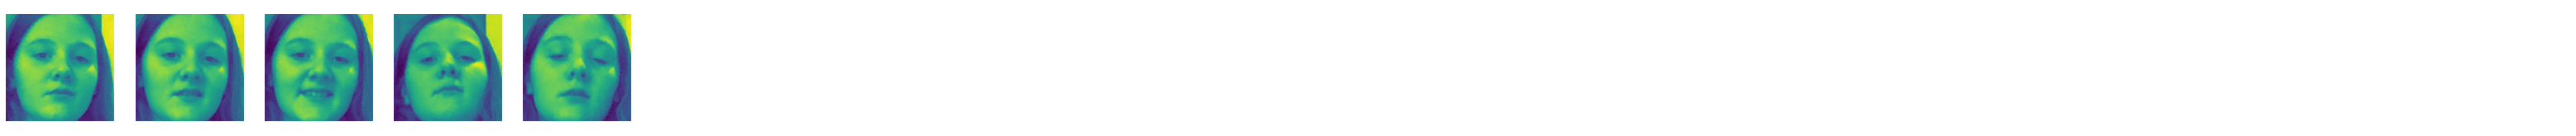

In [ ]:
#@title Let's capture many photos of each person's face
total_count = input("\nHow many photos of {} do you want add? ==>  "
    .format(person_name))

# cast this string variable to an integer
total_count = int(total_count)

for count in range(total_count):
    filename = '{0}/user.{1}.big.jpg'.format(datadir, person_name)
    mesg = 'taking {0} of {1}'.format(count + 1, total_count)
    take_photo(filename, mesg=mesg)
    img = cv2.imread(filename)

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_image, 1.3, 4)

    for (x, y, w, h) in faces:
        face_image = gray_image[y:y+h, x:x+w]
        image_hash = hash_image(face_image)
        # draw a rectangle on the face, for debugging
        #cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
        # Save the captured image into the datasets folder
        subimage_filename = '{0}/user.{1}.{2}.jpg'.format(
            datadir, person_name, image_hash)
        cv2.imwrite(subimage_filename, face_image)
        all_the_training_faces[person_name]['np'].append(face_image)
        pil_image = PIL.Image.open(subimage_filename)
        all_the_training_faces[person_name]['pil'].append(pil_image)

plot_many_peoples_faces(all_the_training_faces)

In [ ]:
#@title Let's create a model from the images we've collected

def organize_faces_for_training(datadir):
    faces_dicts = get_images_with_names(datadir)
    names = list(faces_dicts.keys())
    names.sort()
    ids_to_names = {idx: name for idx, name in enumerate(names)}
    names_to_ids = {name: idx for idx, name in enumerate(names)}
    # counter
    num_samples = Counter()
    # create aligned arrays for input to recognizer.train
    faces = []
    ids = []
    for name in faces_dicts:
        for img in faces_dicts[name]['np']:
            faces.append(img)
            ids.append(names_to_ids[name])
            num_samples[name] += 1
    return faces, np.array(ids), ids_to_names, num_samples

print("Loading data.")
faces, ids, ids_to_names, num_samples = \
    organize_faces_for_training(datadir)

print("Training a model can take a few moments.  Wait ...")
face_recognizer.train(faces, ids)

# Save the model into trainer/trainer.yml
face_model_file_path = os.path.join(
    models_dir, 
    'face_identification_model.yml')

face_recognizer.write(face_model_file_path)

model_metadata = {
    'ids_to_names': dict(ids_to_names),
    'num_training_examples': num_samples,
}

model_metadata_file_path = os.path.join(
    models_dir, 
    'model_metadata.yml')

with open(model_metadata_file_path, 'w') as fh:
    data = yaml.dump(model_export)
    print(data, file=fh)

# Print the numer of faces trained and end program
print("{0} faces trained. Names: \n".format(len(ids_to_names)))
for name, count in num_samples.items():
    print('{0} {1}'.format(count, name))


Loading data.
Training a model can take a few moments.  Wait ...
2 faces trained. Names: 

19 John
6 Holley


# Does it know my name?

Now you are ready to try your trained recognizer# Does it know my name?

Now you are ready to try your trained recognizer!*italicized text*!*italicized text*

<IPython.core.display.Javascript object>

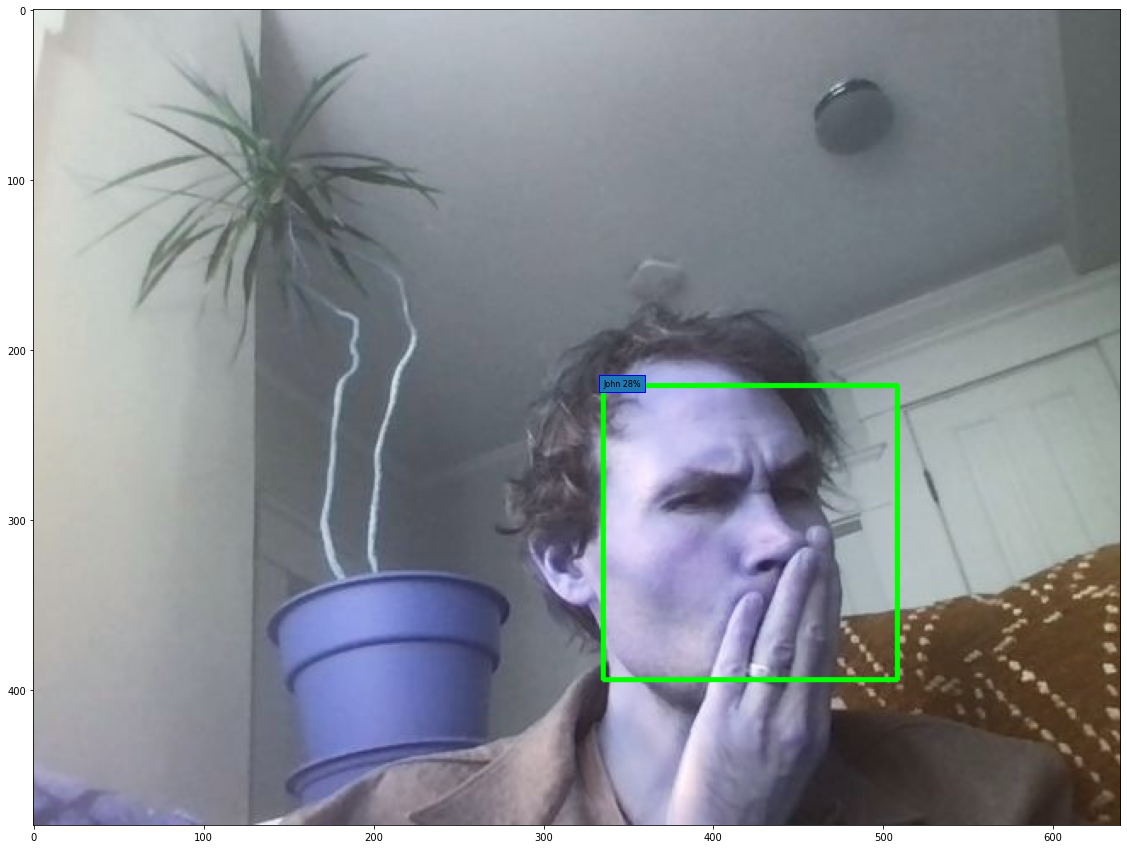

In [ ]:
#@title Load the model file and see what it can do!

# read the model file from the models directory
face_recognizer.read(face_model_file_path)

font = cv2.FONT_HERSHEY_SIMPLEX

filename = take_photo()
img = cv2.imread(filename)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_detector.detectMultiScale(
    gray_image,
    scaleFactor = 1.2,
    minNeighbors = 5,
)

pil_img = PIL.Image.open(filename)
height = (pil_img.size[1] / pil_img.size[0]) * 20
fig, ax = plt.subplots(figsize=(20, height))
for face_idx, (x, y, w, h) in enumerate(faces):
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    face_image = gray_image[y:y+h, x:x+w]
    id, inverted_confidence = face_recognizer.predict(face_image)
    confidence = 100 - inverted_confidence
    if (confidence == 0):
        name = '(unknown)'
    else:
        name = ids_to_names[id]

    mesg = '{0} {1}%'.format(name, round(confidence))
    plt.text(x, y, mesg, fontsize=8, 
             bbox=dict(fill=True, edgecolor='blue', linewidth=1))
    #ax.imshow(im, aspect='auto')

imshow(img)

# Running the Face Identifier on a Raspberry Pi

You'll need to get your Raspberry Pi on to your local wifi.   To do this, you should pull the micro SD card out of the Rpi and put it into the adapter that allows you to mount he micro SD disk volume on to your computer.  It should show up as a volume called "boot"

You need to make a new file in this "boot" volume called: ```boot/wpa_supplicant.conf```

Here's the contents

```
ctrl_interface=DIR=/var/run/wpa_supplicant GROUP=netdev
update_config=1
country=en

network={
 ssid="WIFI NETWORK NAME"
 psk="WIFI PASSWORD"
}
```

Your Rpi has already been configured to allow ssh connections.  I set this up for you by creating a file called "ssh" in the boot directory when first setting up the device.

Once your Rpi connects to your wifi, you can open this link in your browser:  http://raspberrypi.local/
